# Convolutional Neural Networks

In this notebook, we will cover training a simple convolutional neural network on the MNIST dataset, visualizing tuning of model neurons, computing representational similarity analysis (RSA) for different model layers

In [6]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as transforms

## MNIST Dataset

We will use the classical MNIST dataset because it allows rapid training on CPUs.

In [11]:
# Download MNIST dataset
path = Path('./')
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,)),
     ])
trainset = datasets.MNIST(path, train=True, download=True,transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

testset = datasets.MNIST(path, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)

Shape of images from one batch :  torch.Size([16, 1, 28, 28])
Shape of labels from one batch :  torch.Size([16])


Text(0.5, 1.0, 'Label 8')

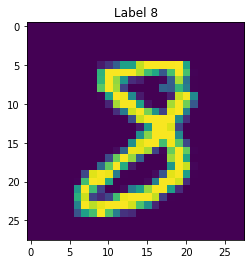

In [24]:
# Visualize an image from the dataset
for i, data in enumerate(train_loader):
    images, labels = data
    break
print('Shape of images from one batch : ', image.shape)
print('Shape of labels from one batch : ', label.shape)

plt.imshow(image[0, 0])
plt.title('Label {}'.format(label[0]))

In [40]:
testset.targets.shape

torch.Size([10000])

## Define a convolutional neural network

In [82]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 7*7 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        # Set whether to readout activation
        self.readout = False

    def forward(self, x):
        # Max pooling over a (2, 2) window
        l1 = F.max_pool2d(F.relu(self.conv1(x)), 2)
        l2 = F.max_pool2d(F.relu(self.conv2(l1)), 2)
        l2_flat = torch.flatten(l2, start_dim=1)  # flatten tensor, while keeping batch dimension
        l3 = F.relu(self.fc1(l2_flat))
        l4 = F.relu(self.fc2(l3))
        y = self.fc3(l4)
        
        if self.readout:
            return {'l1': l1, 'l2': l2, 'l3': l3, 'l4': l4}
        else:
            return y

## Training the network

The following code trains the above network on MNIST until it reaches 95% accuracy. It should take only ~500-1000 training steps.

In [83]:
import torch.optim as optim

# Instantiate the network and print information
net = Net()
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

running_loss = 0
running_acc = 0
for i, data in enumerate(train_loader):
    image, label = data

    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()    # Does the update

    # prediction
    prediction = torch.argmax(output, axis=-1)
    acc = torch.mean((label == prediction).float())

    running_loss += loss.item()
    running_acc += acc
    if i % 100 == 99:
        running_loss /= 100
        running_acc /= 100
        print('Step {}, Loss {:0.4f}, Acc {:0.3f}'.format(
            i+1, running_loss, running_acc))
        if running_acc > 0.95:
            break
        running_loss, running_acc = 0, 0


Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Step 100, Loss 1.0973, Acc 0.619
Step 200, Loss 0.3502, Acc 0.892
Step 300, Loss 0.2853, Acc 0.918
Step 400, Loss 0.2911, Acc 0.917
Step 500, Loss 0.2618, Acc 0.921
Step 600, Loss 0.2794, Acc 0.920
Step 700, Loss 0.2071, Acc 0.941
Step 800, Loss 0.2363, Acc 0.934
Step 900, Loss 0.2160, Acc 0.941
Step 1000, Loss 0.2226, Acc 0.934
Step 1100, Loss 0.1897, Acc 0.952


## Compute representation similarity

We will first compute the neural responses to a batch of images

In [90]:
for i, data in enumerate(test_loader):
    images, labels = data
    break

# Readout network activity
net.readout = True
activity = net(images)

In [92]:
activity['l1'].shape

torch.Size([256, 6, 13, 13])

## Search for preferred stimulus for a given neuron